# Document and Section Similarity Score Predictor using Hash Vectorizer with Calculating Time of Cosine Similarity and Array List response

In [1]:
# python
import time
import pickle
import re, string
import os
import pandas as pd
from os import path, listdir
from pathlib import Path
from os.path import isfile, join
from types import new_class
from typing import List
from lxml import etree 
from contextlib import ExitStack
import sklearn.feature_extraction.text
from nltk.tokenize import PunktSentenceTokenizer, RegexpTokenizer, TreebankWordTokenizer
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.spatial.distance import cosine
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt


# Among the larger bills is samples/congress/116/BILLS-116s1790enr.xml (~ 10MB)

PATH_116_USLM = 'data/samples/congress/116/uslm'
PATH_117_USLM = 'data/samples/congress/117/uslm'
PATH_116_USLM_TRAIN = 'data/samples/congress/116/train'
PATH_116_TEXT = 'data/samples/congress/116/txt'

BILLS_SAMPLE = [f'BILLS-116hr{number}ih.xml' for number in range(100, 300)]
BIG_BILLS = ['BILLS-116s1790enr.xml', 'BILLS-116hjres31enr.xml']
BIG_BILLS_PATHS = [path.join(PATH_116_USLM, bill) for bill in (BIG_BILLS + BILLS_SAMPLE)]

SAMPLE_BILL_PATHS_TRAIN = [join(PATH_116_USLM_TRAIN, f) for f in listdir(PATH_116_USLM) if isfile(join(PATH_116_USLM_TRAIN, f))]
SAMPLE_BILL_PATHS = [join(PATH_117_USLM, f) for f in listdir(PATH_117_USLM) if isfile(join(PATH_117_USLM, f))]


NAMESPACES = {'uslm': 'http://xml.house.gov/schemas/uslm/1.0'}


def get_filepaths(dirpath: str, reMatch = r'.xml$') -> List[str]:
    return [join(dirpath, f) for f in listdir(dirpath) if (len(re.findall(reMatch, f)) > 0) and isfile(join(dirpath, f))]

def getEnum(section) -> str:
  enumpath = section.xpath('enum')  
  if len(enumpath) > 0:
    return enumpath[0].text
  return ''

def getHeader(section) -> str:
  headerpath = section.xpath('header')  
  if len(headerpath) > 0:
    return headerpath[0].text
  return ''

def text_to_vect(txt: str , ngram_size: int = 4):
    """
    Gets ngrams from text
    """
    # See https://stackoverflow.com/a/32128803/628748
    tokenizer = PunktSentenceTokenizer()
    sentences = tokenizer.tokenize(txt)
    #vect = sklearn.feature_extraction.text.CountVectorizer(ngram_range=(ngram_size,ngram_size),
    #    tokenizer=TreebankWordTokenizer().tokenize, lowercase=True)
    vect = sklearn.feature_extraction.text.CountVectorizer(ngram_range=(ngram_size,ngram_size),
        tokenizer=RegexpTokenizer(r"\w+").tokenize, lowercase=True)
    vect.fit(sentences)
    # ngrams = vect.get_feature_names_out()
    # print('{1}-grams: {0}'.format(ngrams, ngram_size))
    #print(vect.vocabulary_)
    return vect # list of text documents

def xml_to_sections(xml_path: str):
    """
    Parses the xml file into sections 
    """
    try:
        billTree = etree.parse(xml_path)
    except:
        raise Exception('Could not parse bill')
    sections = billTree.xpath('//uslm:section', namespaces=NAMESPACES)
    if len(sections) == 0:
        print('No sections found')
        return []
    return [{
            'section_number': getEnum(section) ,
            'section_header':  getHeader(section),
            'section_text': etree.tostring(section, method="text", encoding="unicode"),
            'section_xml': etree.tostring(section, method="xml", encoding="unicode")
        } if (section.xpath('header') and len(section.xpath('header')) > 0  and section.xpath('enum') and len(section.xpath('enum'))>0) else
        {
            'section_number': '',
            'section_header': '', 
            'section_text': etree.tostring(section, method="text", encoding="unicode"),
            'section_xml': etree.tostring(section, method="xml", encoding="unicode")
        } 
        for section in sections ]

def xml_to_text(xml_path: str, level: str = 'section', separator: str = '\n*****\n') -> str:
    """
    Parses the xml file and returns the text of the body element, if any
    """
    try:
        billTree = etree.parse(xml_path)
    except:
        raise Exception('Could not parse bill')
    #return etree.tostring(billTree, method="text", encoding="unicode")
    # Use 'body' for level to get the whole body element
    sections = billTree.xpath('//uslm:'+level, namespaces=NAMESPACES)
    if len(sections) == 0:
        print('No sections found')
        return '' 
    return separator.join([etree.tostring(section, method="text", encoding="unicode") for section in sections])

def xml_to_vect(xml_paths: List[str], ngram_size: int = 4):
    """
    Parses the xml file and returns the text of the body element, if any
    """
    total_str = '\n'.join([xml_to_text(xml_path) for xml_path in xml_paths])
    return text_to_vect(total_str, ngram_size=ngram_size)

    # to get the vocab dict: vect.vocabulary_

def combine_vocabs(vocabs: List[CountVectorizer]):
    """
    Combines one or more vocabs into one
    """
    vocab_keys = list(set([list(v.vocabulary_.keys()) for v in vocabs]))
    vocab = {vocab_key: str(i) for i, vocab_key in enumerate(vocab_keys)}
    return vocab

def get_combined_vocabs(xml_paths: List[str] = SAMPLE_BILL_PATHS, ngram_size: int = 4):
    """
    Gets the combined vocabulary of all the xml files
    """
    return xml_to_vect(xml_paths, ngram_size=ngram_size)

def getSampleText(level = 'body'):
    return xml_to_text(BIG_BILLS_PATHS[0])

def transform_text(text: str, vocab: dict, ngram_size: int = 4):
    """
    Transforms text into a vector using the vocab
    """
    return CountVectorizer(vocabulary=vocab).fit_transform([text])

def train_count_vectorizer(train_data: List[str], ngram_size: int = 4):
    """
    Trains a count vectorizer on the training data
    """
    vectorizer = CountVectorizer(ngram_range=(ngram_size,ngram_size), preprocessor=xml_to_text, tokenizer=RegexpTokenizer(r"\w+").tokenize, lowercase=True)
    with ExitStack() as stack:
        files = [
            stack.enter_context(open(filename))
            for filename in train_data 
        ]
        X = vectorizer.fit_transform(files)
    return vectorizer, X 

def train_hashing_vectorizer(train_data: List[str], ngram_size: int = 4):
    """
    Trains a hashing vectorizer on the training data
    """
    vectorizer = HashingVectorizer(ngram_range=(ngram_size,ngram_size), preprocessor=xml_to_text, tokenizer=RegexpTokenizer(r"\w+").tokenize, lowercase=True)
    with ExitStack() as stack:
        files = [
            stack.enter_context(open(filename))
            for filename in train_data 
        ]
        X = vectorizer.fit_transform(files)
    return vectorizer, X

def test_hashing_vectorizer(vectorizer: HashingVectorizer, test_data: List[str]):
    return vectorizer.transform(test_data)

def xml_samples_to_text(dirpath: str, level: str = 'section', separator: str = '\n*****\n'):
    """
    Converts xml files in a directory to txt files
    """
    xfiles = get_filepaths(dirpath)
    for xfile in xfiles:
        with open(xfile.replace('.xml', f'-{level}s.txt'), 'w') as f:
            f.write(xml_to_text(xfile, level=level, separator=separator))

# TODO: Add a function to parse the bill (text) into paragraphs 

# TODO: create a streaming hash vectorizer. See 
# https://scikit-learn.org/stable/auto_examples/applications/plot_out_of_core_classification.html#sphx-glr-auto-examples-applications-plot-out-of-core-classification-py

# Utility Functions

## 1. Text Cleaning

In [2]:
#clean text 
def text_cleaning(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

##  2. Transform Document into vectorized space

In [3]:
#transform document into vectorized space
def document_hash_vectorized_transformation(document, doc_hash_vectorizer):
    
    doc_vectorized = doc_hash_vectorizer.transform([document])
    return doc_vectorized

def section_doc_hash_vectorized_transformation(section_doc, sec_hash_vectorizer):
    
    section_doc_vectorized = sec_hash_vectorizer.transform(section_doc)
    return section_doc_vectorized


## 3. Calculate Cosine Similarity

In [4]:
# compute cosine pairwise similarity
def cosine_pairwise_sim(a_vectorized, b_vectorized):
    
    #record time for computing similarity 
    start = time.time()

    sim_score =  cosine_similarity(a_vectorized, b_vectorized)

    done = time.time()
    elapsed = done - start
    return elapsed, sim_score

## 4. Create list reponse

In [5]:
#create list response
def create_list_response(A_doc_name, B_doc_name, doc_sim_score, sec_doc_sim_score):
    
    #record time for creating list response
    start = time.time()
    
    #create result list
    res_list = []

    #create empty list
    temp=[]
    temp.append("ORIGINAL DOCUMENT ID: " + A_doc_name)
    temp.append("MATCHED DOCUMENT ID: " + B_doc_name)
    temp.append("DOCUMENT SIMILARITY SCORE: " + str(doc_sim_score[0][0]))

    #iterate over sec_doc_sim_score list 
    for i, section_score_list in enumerate(sec_doc_sim_score):
        
        #add original document sentence id number
        temp.append("ORIGINAL SENTENCE ID: " + str(i+1))
           
        #sort similarity score of sections list
        section_score_list = list(enumerate(section_score_list))
        sorted_section_score_list = sorted(section_score_list, key=lambda x: x[1], reverse=True)
        
        #iterate over section level score only 
        for j, sim_score in sorted_section_score_list:
            temp.append({"MATCHED DOCUMENT ID":  B_doc_name, "MATCHED SENTENCE ID": j+1 , "SENTENCE SIMILARITY SCORE":  sim_score})

    res_list.append(temp)
    
    
    done = time.time()
    elapsed = done - start
    
    return elapsed, res_list

    

## 5. Get Files by Size

In [6]:
#get files by size
def get_files_by_size(to_kb_size, from_kb_size, dir_path):
    """ Returns a list of files that are the size provided """
    result = []
    
    #convert kb into bytes
    to_bytes_size = to_kb_size * 1024
    from_bytes_size = from_kb_size * 1024

    for root, dirs, files in os.walk(dir_path):
        for file in files:
            path = os.path.join(root, file)
            
            file_bytes_size = os.path.getsize(path)

            if (file_bytes_size > to_bytes_size) and (file_bytes_size < from_bytes_size):
                result.append(path)
    return result

# Load Data Corpuses from Disk

In [7]:
# load doc_corpus_data
doc_corpus_data = pickle.load(open("hv_doc_corpus_data.pickel", "rb"))

# load section_corpus_data
section_corpus_data = pickle.load(open("hv_section_corpus_data.pickel", "rb"))



#get only whole document content from doc_corpus_data list
only_doc_data = [row[1] for row in doc_corpus_data]

#get only section content from section_corpus_data list
only_section_data = [row[2] for row in section_corpus_data]


# Load NLP Hash Vectorizer Models

In [8]:
# load hash vectorize instance for only_doc_data
doc_hash_vectorizer = pickle.load(open("doc_hash_vectorizer.pickel", "rb"))

# load hash vectorize instance for only_section_data
sec_hash_vectorizer = pickle.load(open("sec_hash_vectorizer.pickel", "rb"))

# Test Sample Document

## Get Document and Sections Text from  Corpus Data


In [9]:
#pick any Document A & any Document B from data lists (at least that have more than 1 section)
A_doc_name = 'BILLS-117hr1319enr'
B_doc_name = 'BILLS-117hr1319eh'

A_doc = [i[1] for i in doc_corpus_data if A_doc_name ==i[0]][0]
B_doc = [i[1] for i in doc_corpus_data if B_doc_name ==i[0]][0]

A_section_doc = [i[2] for i in section_corpus_data if A_doc_name ==i[0]]
B_section_doc = [i[2] for i in section_corpus_data if B_doc_name ==i[0]]

## Transfomation documents into Vectorization

In [10]:
#transform document A content and document B content
A_doc_vectorized = document_hash_vectorized_transformation(A_doc, doc_hash_vectorizer)
B_doc_vectorized = document_hash_vectorized_transformation(B_doc, doc_hash_vectorizer)

#transform document A section content and  document B section content
A_section_doc_vectorized = section_doc_hash_vectorized_transformation(A_section_doc, sec_hash_vectorizer)
B_section_doc_vectorized = section_doc_hash_vectorized_transformation(B_section_doc, sec_hash_vectorizer)

## Measure Document Similarity Score of any Document A to any Document B

In [11]:
elapsed_1, doc_sim_score = cosine_pairwise_sim(A_doc_vectorized, B_doc_vectorized)

In [12]:
elapsed_1

0.026019811630249023

## Measure Pairwise similraity between Sections of Document A & Sections of Document B

In [13]:
elapsed_2, sec_doc_sim_score = cosine_pairwise_sim(A_section_doc_vectorized, B_section_doc_vectorized)

In [14]:
elapsed_2

0.04903459548950195

## Rendering results of similarity b/w Document A & Document B and their Sections

In [15]:
#get result list response of newly computed similarity score of document A and document B
elapsed_3, response = create_list_response(A_doc_name, B_doc_name, doc_sim_score, sec_doc_sim_score)


In [16]:
elapsed_3

0.30321431159973145

In [17]:
#calculate total time of calculating cosine similarity and creating result response
total_elapsed_time = elapsed_1 + elapsed_2 + elapsed_3

In [18]:
total_elapsed_time

0.3782687187194824

#  Case Testing

In [19]:
#create stats_time_size_analysis
stats_time_size_analysis=[]

## Case # 01

In [20]:
#get file size by size ranges of files
print((get_files_by_size(1, 10, PATH_117_USLM)) [:5])


#create temp list
temp=[]

#append avg size
temp.append(int((1+10)/2))

['data/samples/congress/117/uslm\\BILLS-117hconres10eh.xml', 'data/samples/congress/117/uslm\\BILLS-117hconres10enr.xml', 'data/samples/congress/117/uslm\\BILLS-117hconres10rds.xml', 'data/samples/congress/117/uslm\\BILLS-117hconres12ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hconres15ih.xml']


In [21]:
#pick any Document A & any Document B from data lists (at least that have more than 1 section)
A_doc_name = 'BILLS-117hconres10eh'
B_doc_name = 'BILLS-117hconres10enr'


#get documents by file name
A_doc = [i[1] for i in doc_corpus_data if A_doc_name ==i[0]][0]
B_doc = [i[1] for i in doc_corpus_data if B_doc_name ==i[0]][0]

A_section_doc = [i[2] for i in section_corpus_data if A_doc_name ==i[0]]
B_section_doc = [i[2] for i in section_corpus_data if B_doc_name ==i[0]]


#transform document A content and document B content
A_doc_vectorized = document_hash_vectorized_transformation(A_doc, doc_hash_vectorizer)
B_doc_vectorized = document_hash_vectorized_transformation(B_doc, doc_hash_vectorizer)

#transform document A section content and  document B section content
A_section_doc_vectorized = section_doc_hash_vectorized_transformation(A_section_doc, sec_hash_vectorizer)
B_section_doc_vectorized = section_doc_hash_vectorized_transformation(B_section_doc, sec_hash_vectorizer)


#calculate pairwise similarity 
elapsed_1, doc_sim_score = cosine_pairwise_sim(A_doc_vectorized, B_doc_vectorized)
elapsed_2, sec_doc_sim_score = cosine_pairwise_sim(A_section_doc_vectorized, B_section_doc_vectorized)
elapsed_3, response = create_list_response(A_doc_name, B_doc_name, doc_sim_score, sec_doc_sim_score)

total_elapsed_time = elapsed_1 + elapsed_2 + elapsed_3

#append total_elapsed_time
temp.append(total_elapsed_time)

#append temp list into stats_time_size_analysis
stats_time_size_analysis.append(temp)

print(elapsed_1, doc_sim_score)
print(elapsed_2)
print(elapsed_3)

print(total_elapsed_time)


0.017010927200317383 [[1.]]
0.01701211929321289
0.0
0.03402304649353027


## Case # 02

In [22]:
#get file size by size ranges of files
print(sorted(get_files_by_size(11, 20, PATH_117_USLM)) [20:50])


#create temp list
temp=[]

#append avg size
temp.append(int((11+20)/2))


['data/samples/congress/117/uslm\\BILLS-117hr1069ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1075ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1079eh.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1079ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1079rfs.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1083eh.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1083ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1083rfs.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1085ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1087ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1087rh.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1090ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1093ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1097ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr109ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1106ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1109ih.xml', 'data/samples/congress/117/us

In [23]:
#pick any Document A & any Document B from data lists (at least that have more than 1 section)
A_doc_name = 'BILLS-117hr1079eh'
B_doc_name = 'BILLS-117hr1079ih'

#get documents by file name
A_doc = [i[1] for i in doc_corpus_data if A_doc_name ==i[0]][0]
B_doc = [i[1] for i in doc_corpus_data if B_doc_name ==i[0]][0]

A_section_doc = [i[2] for i in section_corpus_data if A_doc_name ==i[0]]
B_section_doc = [i[2] for i in section_corpus_data if B_doc_name ==i[0]]


#transform document A content and document B content
A_doc_vectorized = document_hash_vectorized_transformation(A_doc, doc_hash_vectorizer)
B_doc_vectorized = document_hash_vectorized_transformation(B_doc, doc_hash_vectorizer)

#transform document A section content and  document B section content
A_section_doc_vectorized = section_doc_hash_vectorized_transformation(A_section_doc, sec_hash_vectorizer)
B_section_doc_vectorized = section_doc_hash_vectorized_transformation(B_section_doc, sec_hash_vectorizer)


#calculate pairwise similarity 
elapsed_1, doc_sim_score = cosine_pairwise_sim(A_doc_vectorized, B_doc_vectorized)
elapsed_2, sec_doc_sim_score = cosine_pairwise_sim(A_section_doc_vectorized, B_section_doc_vectorized)
elapsed_3, response = create_list_response(A_doc_name, B_doc_name, doc_sim_score, sec_doc_sim_score)

total_elapsed_time = elapsed_1 + elapsed_2 + elapsed_3

#append total_elapsed_time
temp.append(total_elapsed_time)

#append temp list into stats_time_size_analysis
stats_time_size_analysis.append(temp)

print(elapsed_1, doc_sim_score)
print(elapsed_2)
print(elapsed_3)

print(total_elapsed_time)


0.011008739471435547 [[0.9893243]]
0.017013072967529297
0.0
0.028021812438964844


## Case # 03

In [24]:

#get file size by size ranges of files
print(sorted(get_files_by_size(21, 30, PATH_117_USLM)) [0:20])


#create temp list
temp=[]

#append avg size
temp.append(int((21+30)/2))


['data/samples/congress/117/uslm\\BILLS-117hr1006ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1037ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1047ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1051ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1060ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1064ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1065eh.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1065ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1065rfs.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1077ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1078ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1091ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1096ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1100ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1126ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1131ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1134ih.xml', 'data/samples/congress/117/us

In [25]:
#pick any Document A & any Document B from data lists (at least that have more than 1 section)
A_doc_name = 'BILLS-117hr1065eh'
B_doc_name = 'BILLS-117hr1065ih'

#get documents by file name
A_doc = [i[1] for i in doc_corpus_data if A_doc_name ==i[0]][0]
B_doc = [i[1] for i in doc_corpus_data if B_doc_name ==i[0]][0]

A_section_doc = [i[2] for i in section_corpus_data if A_doc_name ==i[0]]
B_section_doc = [i[2] for i in section_corpus_data if B_doc_name ==i[0]]


#transform document A content and document B content
A_doc_vectorized = document_hash_vectorized_transformation(A_doc, doc_hash_vectorizer)
B_doc_vectorized = document_hash_vectorized_transformation(B_doc, doc_hash_vectorizer)

#transform document A section content and  document B section content
A_section_doc_vectorized = section_doc_hash_vectorized_transformation(A_section_doc, sec_hash_vectorizer)
B_section_doc_vectorized = section_doc_hash_vectorized_transformation(B_section_doc, sec_hash_vectorizer)


#calculate pairwise similarity 
elapsed_1, doc_sim_score = cosine_pairwise_sim(A_doc_vectorized, B_doc_vectorized)
elapsed_2, sec_doc_sim_score = cosine_pairwise_sim(A_section_doc_vectorized, B_section_doc_vectorized)
elapsed_3, response = create_list_response(A_doc_name, B_doc_name, doc_sim_score, sec_doc_sim_score)

total_elapsed_time = elapsed_1 + elapsed_2 + elapsed_3

#append total_elapsed_time
temp.append(total_elapsed_time)

#append temp list into stats_time_size_analysis
stats_time_size_analysis.append(temp)

print(elapsed_1, doc_sim_score)
print(elapsed_2)
print(elapsed_3)

print(total_elapsed_time)


0.017012596130371094 [[1.]]
0.012005805969238281
0.0
0.029018402099609375


## Case # 04

In [26]:
print(sorted(get_files_by_size(31, 50, PATH_117_USLM)) [:])

#create temp list
temp=[]

#append avg size
temp.append(int((31+ 50)/2))


['data/samples/congress/117/uslm\\BILLS-117hr1008ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1030ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1040ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1054ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1065rh.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1080ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1082ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr111ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1163ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1182ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1183ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1197ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1201ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1221ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1225ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1234ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1242ih.xml', 'data/samples/congress/117/uslm

In [27]:
#pick any Document A & any Document B from data lists (at least that have more than 1 section)
A_doc_name = 'BILLS-117hr1490eh'
B_doc_name = 'BILLS-117hr1490ih'

#get documents by file name
A_doc = [i[1] for i in doc_corpus_data if A_doc_name ==i[0]][0]
B_doc = [i[1] for i in doc_corpus_data if B_doc_name ==i[0]][0]

A_section_doc = [i[2] for i in section_corpus_data if A_doc_name ==i[0]]
B_section_doc = [i[2] for i in section_corpus_data if B_doc_name ==i[0]]


#transform document A content and document B content
A_doc_vectorized = document_hash_vectorized_transformation(A_doc, doc_hash_vectorizer)
B_doc_vectorized = document_hash_vectorized_transformation(B_doc, doc_hash_vectorizer)

#transform document A section content and  document B section content
A_section_doc_vectorized = section_doc_hash_vectorized_transformation(A_section_doc, sec_hash_vectorizer)
B_section_doc_vectorized = section_doc_hash_vectorized_transformation(B_section_doc, sec_hash_vectorizer)


#calculate pairwise similarity 
elapsed_1, doc_sim_score = cosine_pairwise_sim(A_doc_vectorized, B_doc_vectorized)
elapsed_2, sec_doc_sim_score = cosine_pairwise_sim(A_section_doc_vectorized, B_section_doc_vectorized)
elapsed_3, response = create_list_response(A_doc_name, B_doc_name, doc_sim_score, sec_doc_sim_score)

total_elapsed_time = elapsed_1 + elapsed_2 + elapsed_3

#append total_elapsed_time
temp.append(total_elapsed_time)

#append temp list into stats_time_size_analysis
stats_time_size_analysis.append(temp)

print(elapsed_1, doc_sim_score)
print(elapsed_2)
print(elapsed_3)

print(total_elapsed_time)


0.012009382247924805 [[1.]]
0.011008739471435547
0.0
0.02301812171936035


## Case # 05

In [28]:
print(sorted(get_files_by_size(50, 100, PATH_117_USLM)) [5:20])

#create temp list
temp=[]

#append avg size
temp.append(int((50 + 100)/2))


['data/samples/congress/117/uslm\\BILLS-117hr1144eh.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1144ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1144rfs.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1144rh.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1155ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1171ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1195eh.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1195ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1195rfs.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1195rh.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1212ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1226ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1227ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1228ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1238ih.xml']


In [29]:
#pick any Document A & any Document B from data lists (at least that have more than 1 section)
A_doc_name = 'BILLS-117hr1144eh'
B_doc_name = 'BILLS-117hr1144ih'

#get documents by file name
A_doc = [i[1] for i in doc_corpus_data if A_doc_name ==i[0]][0]
B_doc = [i[1] for i in doc_corpus_data if B_doc_name ==i[0]][0]

A_section_doc = [i[2] for i in section_corpus_data if A_doc_name ==i[0]]
B_section_doc = [i[2] for i in section_corpus_data if B_doc_name ==i[0]]


#transform document A content and document B content
A_doc_vectorized = document_hash_vectorized_transformation(A_doc, doc_hash_vectorizer)
B_doc_vectorized = document_hash_vectorized_transformation(B_doc, doc_hash_vectorizer)

#transform document A section content and  document B section content
A_section_doc_vectorized = section_doc_hash_vectorized_transformation(A_section_doc, sec_hash_vectorizer)
B_section_doc_vectorized = section_doc_hash_vectorized_transformation(B_section_doc, sec_hash_vectorizer)


#calculate pairwise similarity 
elapsed_1, doc_sim_score = cosine_pairwise_sim(A_doc_vectorized, B_doc_vectorized)
elapsed_2, sec_doc_sim_score = cosine_pairwise_sim(A_section_doc_vectorized, B_section_doc_vectorized)
elapsed_3, response = create_list_response(A_doc_name, B_doc_name, doc_sim_score, sec_doc_sim_score)

total_elapsed_time = elapsed_1 + elapsed_2 + elapsed_3

#append total_elapsed_time
temp.append(total_elapsed_time)

#append temp list into stats_time_size_analysis
stats_time_size_analysis.append(temp)

print(elapsed_1, doc_sim_score)
print(elapsed_2)
print(elapsed_3)

print(total_elapsed_time)


0.015627145767211914 [[0.91424511]]
0.0
0.0
0.015627145767211914


## ## Case # 06 

In [30]:
print(sorted(get_files_by_size(101, 150, PATH_117_USLM)) [50:80])

#create temp list
temp=[]

#append avg size
temp.append(int((101 + 150)/2))


['data/samples/congress/117/uslm\\BILLS-117hr4346rfs.xml', 'data/samples/congress/117/uslm\\BILLS-117hr4346rh.xml', 'data/samples/congress/117/uslm\\BILLS-117hr4355rh.xml', 'data/samples/congress/117/uslm\\BILLS-117hr4375ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr4403ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr4442ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr4509ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr4549rh.xml', 'data/samples/congress/117/uslm\\BILLS-117hr4609ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr4720ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr4741ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr476ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr4801ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr4828ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr594ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr59ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr602ih.xml', 'data/samples/congress/117/uslm\\B

In [31]:
#pick any Document A & any Document B from data lists (at least that have more than 1 section)
A_doc_name = 'BILLS-117hr6eh'
B_doc_name = 'BILLS-117hr6ih'

#get documents by file name
A_doc = [i[1] for i in doc_corpus_data if A_doc_name ==i[0]][0]
B_doc = [i[1] for i in doc_corpus_data if B_doc_name ==i[0]][0]

A_section_doc = [i[2] for i in section_corpus_data if A_doc_name ==i[0]]
B_section_doc = [i[2] for i in section_corpus_data if B_doc_name ==i[0]]


#transform document A content and document B content
A_doc_vectorized = document_hash_vectorized_transformation(A_doc, doc_hash_vectorizer)
B_doc_vectorized = document_hash_vectorized_transformation(B_doc, doc_hash_vectorizer)

#transform document A section content and  document B section content
A_section_doc_vectorized = section_doc_hash_vectorized_transformation(A_section_doc, sec_hash_vectorizer)
B_section_doc_vectorized = section_doc_hash_vectorized_transformation(B_section_doc, sec_hash_vectorizer)


#calculate pairwise similarity 
elapsed_1, doc_sim_score = cosine_pairwise_sim(A_doc_vectorized, B_doc_vectorized)
elapsed_2, sec_doc_sim_score = cosine_pairwise_sim(A_section_doc_vectorized, B_section_doc_vectorized)
elapsed_3, response = create_list_response(A_doc_name, B_doc_name, doc_sim_score, sec_doc_sim_score)

total_elapsed_time = elapsed_1 + elapsed_2 + elapsed_3

#append total_elapsed_time
temp.append(total_elapsed_time)

#append temp list into stats_time_size_analysis
stats_time_size_analysis.append(temp)

print(elapsed_1, doc_sim_score)
print(elapsed_2)
print(elapsed_3)

print(total_elapsed_time)


0.0 [[0.9944179]]
0.01560211181640625
0.0
0.01560211181640625


## Case # 07

In [32]:
print(sorted(get_files_by_size(200, 300, PATH_117_USLM)) [10:30])

#create temp list
temp=[]

#append avg size
temp.append(int((200 + 300)/2))

['data/samples/congress/117/uslm\\BILLS-117hr2718ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr2768ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr2817ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr2886ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr2954ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr3404ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr3473ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr3593eh.xml', 'data/samples/congress/117/uslm\\BILLS-117hr3593ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr3593rfs.xml', 'data/samples/congress/117/uslm\\BILLS-117hr3593rh.xml', 'data/samples/congress/117/uslm\\BILLS-117hr4334ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr4341ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr4372rh.xml', 'data/samples/congress/117/uslm\\BILLS-117hr4431rh.xml', 'data/samples/congress/117/uslm\\BILLS-117hr4432rh.xml', 'data/samples/congress/117/uslm\\BILLS-117hr4497ih.xml', 'data/samples/congress/117/us

In [33]:
#pick any Document A & any Document B from data lists (at least that have more than 1 section)
A_doc_name = 'BILLS-117hr3593eh'
B_doc_name = 'BILLS-117hr3593ih'

#get documents by file name
A_doc = [i[1] for i in doc_corpus_data if A_doc_name ==i[0]][0]
B_doc = [i[1] for i in doc_corpus_data if B_doc_name ==i[0]][0]

A_section_doc = [i[2] for i in section_corpus_data if A_doc_name ==i[0]]
B_section_doc = [i[2] for i in section_corpus_data if B_doc_name ==i[0]]


#transform document A content and document B content
A_doc_vectorized = document_hash_vectorized_transformation(A_doc, doc_hash_vectorizer)
B_doc_vectorized = document_hash_vectorized_transformation(B_doc, doc_hash_vectorizer)

#transform document A section content and  document B section content
A_section_doc_vectorized = section_doc_hash_vectorized_transformation(A_section_doc, sec_hash_vectorizer)
B_section_doc_vectorized = section_doc_hash_vectorized_transformation(B_section_doc, sec_hash_vectorizer)


#calculate pairwise similarity 
elapsed_1, doc_sim_score = cosine_pairwise_sim(A_doc_vectorized, B_doc_vectorized)
elapsed_2, sec_doc_sim_score = cosine_pairwise_sim(A_section_doc_vectorized, B_section_doc_vectorized)
elapsed_3, response = create_list_response(A_doc_name, B_doc_name, doc_sim_score, sec_doc_sim_score)

total_elapsed_time = elapsed_1 + elapsed_2 + elapsed_3

#append total_elapsed_time
temp.append(total_elapsed_time)

#append temp list into stats_time_size_analysis
stats_time_size_analysis.append(temp)

print(elapsed_1, doc_sim_score)
print(elapsed_2)
print(elapsed_3)

print(total_elapsed_time)


0.0 [[0.90970324]]
0.015620708465576172
0.0
0.015620708465576172


## Case # 08

In [34]:
print(sorted(get_files_by_size(300, 400, PATH_117_USLM)) [10:30])

#create temp list
temp=[]

#append avg size
temp.append(int((300 + 400)/2))

['data/samples/congress/117/uslm\\BILLS-117hr2731ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr3435ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr3ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr4153ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr4345rh.xml', 'data/samples/congress/117/uslm\\BILLS-117hr447eh.xml', 'data/samples/congress/117/uslm\\BILLS-117hr447ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr447rfs.xml', 'data/samples/congress/117/uslm\\BILLS-117hr4502rh.xml', 'data/samples/congress/117/uslm\\BILLS-117hr4550rh.xml', 'data/samples/congress/117/uslm\\BILLS-117s1260is.xml', 'data/samples/congress/117/uslm\\BILLS-117s1276is.xml', 'data/samples/congress/117/uslm\\BILLS-117s1298is.xml', 'data/samples/congress/117/uslm\\BILLS-117s1770is.xml', 'data/samples/congress/117/uslm\\BILLS-117s1927is.xml', 'data/samples/congress/117/uslm\\BILLS-117s2401rs.xml', 'data/samples/congress/117/uslm\\BILLS-117s2569is.xml', 'data/samples/congress/117/uslm\\BILLS-117

In [35]:
#pick any Document A & any Document B from data lists (at least that have more than 1 section)
A_doc_name = 'BILLS-117hr447eh'
B_doc_name = 'BILLS-117hr447ih'

#get documents by file name
A_doc = [i[1] for i in doc_corpus_data if A_doc_name ==i[0]][0]
B_doc = [i[1] for i in doc_corpus_data if B_doc_name ==i[0]][0]

A_section_doc = [i[2] for i in section_corpus_data if A_doc_name ==i[0]]
B_section_doc = [i[2] for i in section_corpus_data if B_doc_name ==i[0]]


#transform document A content and document B content
A_doc_vectorized = document_hash_vectorized_transformation(A_doc, doc_hash_vectorizer)
B_doc_vectorized = document_hash_vectorized_transformation(B_doc, doc_hash_vectorizer)

#transform document A section content and  document B section content
A_section_doc_vectorized = section_doc_hash_vectorized_transformation(A_section_doc, sec_hash_vectorizer)
B_section_doc_vectorized = section_doc_hash_vectorized_transformation(B_section_doc, sec_hash_vectorizer)


#calculate pairwise similarity 
elapsed_1, doc_sim_score = cosine_pairwise_sim(A_doc_vectorized, B_doc_vectorized)
elapsed_2, sec_doc_sim_score = cosine_pairwise_sim(A_section_doc_vectorized, B_section_doc_vectorized)
elapsed_3, response = create_list_response(A_doc_name, B_doc_name, doc_sim_score, sec_doc_sim_score)

total_elapsed_time = elapsed_1 + elapsed_2 + elapsed_3

#append total_elapsed_time
temp.append(total_elapsed_time)

#append temp list into stats_time_size_analysis
stats_time_size_analysis.append(temp)

print(elapsed_1, doc_sim_score)
print(elapsed_2)
print(elapsed_3)

print(total_elapsed_time)


0.0 [[0.98970054]]
0.01563119888305664
0.015620231628417969
0.03125143051147461


## Case # 09

In [36]:
print(sorted(get_files_by_size(400, 500, PATH_117_USLM)) [0:30])

#create temp list
temp=[]

#append avg size
temp.append(int((400 + 500)/2))

['data/samples/congress/117/uslm\\BILLS-117hr1537ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1603eh.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1603ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1603rfs.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1783ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr2803ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr3000ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr4128ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr4309ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr4690ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr959ih.xml', 'data/samples/congress/117/uslm\\BILLS-117s1201is.xml', 'data/samples/congress/117/uslm\\BILLS-117s1275rs.xml', 'data/samples/congress/117/uslm\\BILLS-117s1337is.xml', 'data/samples/congress/117/uslm\\BILLS-117s1459is.xml', 'data/samples/congress/117/uslm\\BILLS-117s2209is.xml', 'data/samples/congress/117/uslm\\BILLS-117s2297rs.xml', 'data/samples/congress/117/uslm\\BIL

In [37]:
#pick any Document A & any Document B from data lists (at least that have more than 1 section)
A_doc_name = 'BILLS-117hr1603eh'
B_doc_name = 'BILLS-117hr1603ih'

#get documents by file name
A_doc = [i[1] for i in doc_corpus_data if A_doc_name ==i[0]][0]
B_doc = [i[1] for i in doc_corpus_data if B_doc_name ==i[0]][0]

A_section_doc = [i[2] for i in section_corpus_data if A_doc_name ==i[0]]
B_section_doc = [i[2] for i in section_corpus_data if B_doc_name ==i[0]]


#transform document A content and document B content
A_doc_vectorized = document_hash_vectorized_transformation(A_doc, doc_hash_vectorizer)
B_doc_vectorized = document_hash_vectorized_transformation(B_doc, doc_hash_vectorizer)

#transform document A section content and  document B section content
A_section_doc_vectorized = section_doc_hash_vectorized_transformation(A_section_doc, sec_hash_vectorizer)
B_section_doc_vectorized = section_doc_hash_vectorized_transformation(B_section_doc, sec_hash_vectorizer)


#calculate pairwise similarity 
elapsed_1, doc_sim_score = cosine_pairwise_sim(A_doc_vectorized, B_doc_vectorized)
elapsed_2, sec_doc_sim_score = cosine_pairwise_sim(A_section_doc_vectorized, B_section_doc_vectorized)
elapsed_3, response = create_list_response(A_doc_name, B_doc_name, doc_sim_score, sec_doc_sim_score)

total_elapsed_time = elapsed_1 + elapsed_2 + elapsed_3

#append total_elapsed_time
temp.append(total_elapsed_time)

#append temp list into stats_time_size_analysis
stats_time_size_analysis.append(temp)

print(elapsed_1, doc_sim_score)
print(elapsed_2)
print(elapsed_3)

print(total_elapsed_time)


0.0 [[0.9995695]]
0.020198822021484375
0.015662431716918945
0.03586125373840332


## Case # 10

In [38]:
print(sorted(get_files_by_size(500, 800, PATH_117_USLM)) [10:30])

#create temp list
temp=[]

#append avg size
temp.append(int((500 + 800)/2))

['data/samples/congress/117/uslm\\BILLS-117s1169is.xml', 'data/samples/congress/117/uslm\\BILLS-117s192is.xml', 'data/samples/congress/117/uslm\\BILLS-117s2118pcs.xml', 'data/samples/congress/117/uslm\\BILLS-117s348is.xml', 'data/samples/congress/117/uslm\\BILLS-117s954is.xml']


In [39]:
#pick any Document A & any Document B from data lists (at least that have more than 1 section)
A_doc_name = 'BILLS-117hr447eh'
B_doc_name = 'BILLS-117hr447ih'

#get documents by file name
A_doc = [i[1] for i in doc_corpus_data if A_doc_name ==i[0]][0]
B_doc = [i[1] for i in doc_corpus_data if B_doc_name ==i[0]][0]

A_section_doc = [i[2] for i in section_corpus_data if A_doc_name ==i[0]]
B_section_doc = [i[2] for i in section_corpus_data if B_doc_name ==i[0]]


#transform document A content and document B content
A_doc_vectorized = document_hash_vectorized_transformation(A_doc, doc_hash_vectorizer)
B_doc_vectorized = document_hash_vectorized_transformation(B_doc, doc_hash_vectorizer)

#transform document A section content and  document B section content
A_section_doc_vectorized = section_doc_hash_vectorized_transformation(A_section_doc, sec_hash_vectorizer)
B_section_doc_vectorized = section_doc_hash_vectorized_transformation(B_section_doc, sec_hash_vectorizer)


#calculate pairwise similarity 
elapsed_1, doc_sim_score = cosine_pairwise_sim(A_doc_vectorized, B_doc_vectorized)
elapsed_2, sec_doc_sim_score = cosine_pairwise_sim(A_section_doc_vectorized, B_section_doc_vectorized)
elapsed_3, response = create_list_response(A_doc_name, B_doc_name, doc_sim_score, sec_doc_sim_score)

total_elapsed_time = elapsed_1 + elapsed_2 + elapsed_3

#append total_elapsed_time
temp.append(total_elapsed_time)

#append temp list into stats_time_size_analysis
stats_time_size_analysis.append(temp)

print(elapsed_1, doc_sim_score)
print(elapsed_2)
print(elapsed_3)

print(total_elapsed_time)


0.015631437301635742 [[0.98970054]]
0.015624284744262695
0.0
0.03125572204589844


## Case # 11

In [40]:
print(sorted(get_files_by_size(800, 1000, PATH_117_USLM)) [:])

#create temp list
temp=[]

#append avg size
temp.append(int((800 + 1000)/2))

['data/samples/congress/117/uslm\\BILLS-117hr3524ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr803eh.xml', 'data/samples/congress/117/uslm\\BILLS-117hr803rfs.xml', 'data/samples/congress/117/uslm\\BILLS-117s589is.xml']


In [41]:
#pick any Document A & any Document B from data lists (at least that have more than 1 section)
A_doc_name = 'BILLS-117hr803eh'
B_doc_name = 'BILLS-117hr803rfs'

#get documents by file name
A_doc = [i[1] for i in doc_corpus_data if A_doc_name ==i[0]][0]
B_doc = [i[1] for i in doc_corpus_data if B_doc_name ==i[0]][0]

A_section_doc = [i[2] for i in section_corpus_data if A_doc_name ==i[0]]
B_section_doc = [i[2] for i in section_corpus_data if B_doc_name ==i[0]]


#transform document A content and document B content
A_doc_vectorized = document_hash_vectorized_transformation(A_doc, doc_hash_vectorizer)
B_doc_vectorized = document_hash_vectorized_transformation(B_doc, doc_hash_vectorizer)

#transform document A section content and  document B section content
A_section_doc_vectorized = section_doc_hash_vectorized_transformation(A_section_doc, sec_hash_vectorizer)
B_section_doc_vectorized = section_doc_hash_vectorized_transformation(B_section_doc, sec_hash_vectorizer)


#calculate pairwise similarity 
elapsed_1, doc_sim_score = cosine_pairwise_sim(A_doc_vectorized, B_doc_vectorized)
elapsed_2, sec_doc_sim_score = cosine_pairwise_sim(A_section_doc_vectorized, B_section_doc_vectorized)
elapsed_3, response = create_list_response(A_doc_name, B_doc_name, doc_sim_score, sec_doc_sim_score)

total_elapsed_time = elapsed_1 + elapsed_2 + elapsed_3

#append total_elapsed_time
temp.append(total_elapsed_time)

#append temp list into stats_time_size_analysis
stats_time_size_analysis.append(temp)

print(elapsed_1, doc_sim_score)
print(elapsed_2)
print(elapsed_3)

print(total_elapsed_time)


0.01562643051147461 [[1.]]
0.03122687339782715
0.03125429153442383
0.07810759544372559


## Case # 12

In [42]:
print(sorted(get_files_by_size(1000, 1500, PATH_117_USLM)) [:])

#create temp list
temp=[]

#append avg size
temp.append(int((1000 + 1500)/2))

['data/samples/congress/117/uslm\\BILLS-117hr1319eas.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1319eh.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1319enr.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1319pcs.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1319rh.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1848ih.xml', 'data/samples/congress/117/uslm\\BILLS-117s1931rs.xml', 'data/samples/congress/117/uslm\\BILLS-117s1953is.xml', 'data/samples/congress/117/uslm\\BILLS-117s2016is.xml', 'data/samples/congress/117/uslm\\BILLS-117s2377rs.xml']


In [43]:
#pick any Document A & any Document B from data lists (at least that have more than 1 section)
A_doc_name = 'BILLS-117hr1319pcs'
B_doc_name = 'BILLS-117hr1319rh'

#get documents by file name
A_doc = [i[1] for i in doc_corpus_data if A_doc_name ==i[0]][0]
B_doc = [i[1] for i in doc_corpus_data if B_doc_name ==i[0]][0]

A_section_doc = [i[2] for i in section_corpus_data if A_doc_name ==i[0]]
B_section_doc = [i[2] for i in section_corpus_data if B_doc_name ==i[0]]


#transform document A content and document B content
A_doc_vectorized = document_hash_vectorized_transformation(A_doc, doc_hash_vectorizer)
B_doc_vectorized = document_hash_vectorized_transformation(B_doc, doc_hash_vectorizer)

#transform document A section content and  document B section content
A_section_doc_vectorized = section_doc_hash_vectorized_transformation(A_section_doc, sec_hash_vectorizer)
B_section_doc_vectorized = section_doc_hash_vectorized_transformation(B_section_doc, sec_hash_vectorizer)


#calculate pairwise similarity 
elapsed_1, doc_sim_score = cosine_pairwise_sim(A_doc_vectorized, B_doc_vectorized)
elapsed_2, sec_doc_sim_score = cosine_pairwise_sim(A_section_doc_vectorized, B_section_doc_vectorized)
elapsed_3, response = create_list_response(A_doc_name, B_doc_name, doc_sim_score, sec_doc_sim_score)

total_elapsed_time = elapsed_1 + elapsed_2 + elapsed_3

#append total_elapsed_time
temp.append(total_elapsed_time)

#append temp list into stats_time_size_analysis
stats_time_size_analysis.append(temp)

print(elapsed_1, doc_sim_score)
print(elapsed_2)
print(elapsed_3)

print(total_elapsed_time)


0.01565408706665039 [[0.94887329]]
0.03124547004699707
0.07812142372131348
0.12502098083496094


## Case # 13

In [44]:
print(sorted(get_files_by_size(1500, 2000, PATH_117_USLM)) [:])

#create temp list
temp=[]

#append avg size
temp.append(int((1500 + 2000)/2))

['data/samples/congress/117/uslm\\BILLS-117hr1ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr4502eh.xml', 'data/samples/congress/117/uslm\\BILLS-117s1169rs.xml', 'data/samples/congress/117/uslm\\BILLS-117s1260rs.xml', 'data/samples/congress/117/uslm\\BILLS-117s1is.xml', 'data/samples/congress/117/uslm\\BILLS-117s1pcs.xml', 'data/samples/congress/117/uslm\\BILLS-117s2093pcs.xml']


In [45]:
#pick any Document A & any Document B from data lists (at least that have more than 1 section)
A_doc_name = 'BILLS-117s1is'
B_doc_name = 'BILLS-117s1pcs'

#get documents by file name
A_doc = [i[1] for i in doc_corpus_data if A_doc_name ==i[0]][0]
B_doc = [i[1] for i in doc_corpus_data if B_doc_name ==i[0]][0]

A_section_doc = [i[2] for i in section_corpus_data if A_doc_name ==i[0]]
B_section_doc = [i[2] for i in section_corpus_data if B_doc_name ==i[0]]


#transform document A content and document B content
A_doc_vectorized = document_hash_vectorized_transformation(A_doc, doc_hash_vectorizer)
B_doc_vectorized = document_hash_vectorized_transformation(B_doc, doc_hash_vectorizer)

#transform document A section content and  document B section content
A_section_doc_vectorized = section_doc_hash_vectorized_transformation(A_section_doc, sec_hash_vectorizer)
B_section_doc_vectorized = section_doc_hash_vectorized_transformation(B_section_doc, sec_hash_vectorizer)


#calculate pairwise similarity 
elapsed_1, doc_sim_score = cosine_pairwise_sim(A_doc_vectorized, B_doc_vectorized)
elapsed_2, sec_doc_sim_score = cosine_pairwise_sim(A_section_doc_vectorized, B_section_doc_vectorized)
elapsed_3, response = create_list_response(A_doc_name, B_doc_name, doc_sim_score, sec_doc_sim_score)

total_elapsed_time = elapsed_1 + elapsed_2 + elapsed_3

#append total_elapsed_time
temp.append(total_elapsed_time)

#append temp list into stats_time_size_analysis
stats_time_size_analysis.append(temp)

print(elapsed_1, doc_sim_score)
print(elapsed_2)
print(elapsed_3)

print(total_elapsed_time)


0.015618562698364258 [[1.]]
0.04688525199890137
0.31247806549072266
0.3749818801879883


## Case # 14

In [46]:
print(sorted(get_files_by_size(2000, 5000, PATH_117_USLM)) [:])

#create temp list
temp=[]

#append avg size
temp.append(int((2000 + 5000)/2))

['data/samples/congress/117/uslm\\BILLS-117hr1512ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr1eh.xml', 'data/samples/congress/117/uslm\\BILLS-117hr3684ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr3684rh.xml', 'data/samples/congress/117/uslm\\BILLS-117hr3975ih.xml', 'data/samples/congress/117/uslm\\BILLS-117hr4037ih.xml']


In [47]:
#pick any Document A & any Document B from data lists (at least that have more than 1 section)
A_doc_name = 'BILLS-117hr3684ih'
B_doc_name = 'BILLS-117hr3684rh'

#get documents by file name
A_doc = [i[1] for i in doc_corpus_data if A_doc_name ==i[0]][0]
B_doc = [i[1] for i in doc_corpus_data if B_doc_name ==i[0]][0]

A_section_doc = [i[2] for i in section_corpus_data if A_doc_name ==i[0]]
B_section_doc = [i[2] for i in section_corpus_data if B_doc_name ==i[0]]


#transform document A content and document B content
A_doc_vectorized = document_hash_vectorized_transformation(A_doc, doc_hash_vectorizer)
B_doc_vectorized = document_hash_vectorized_transformation(B_doc, doc_hash_vectorizer)

#transform document A section content and  document B section content
A_section_doc_vectorized = section_doc_hash_vectorized_transformation(A_section_doc, sec_hash_vectorizer)
B_section_doc_vectorized = section_doc_hash_vectorized_transformation(B_section_doc, sec_hash_vectorizer)


#calculate pairwise similarity 
elapsed_1, doc_sim_score = cosine_pairwise_sim(A_doc_vectorized, B_doc_vectorized)
elapsed_2, sec_doc_sim_score = cosine_pairwise_sim(A_section_doc_vectorized, B_section_doc_vectorized)
elapsed_3, response = create_list_response(A_doc_name, B_doc_name, doc_sim_score, sec_doc_sim_score)

total_elapsed_time = elapsed_1 + elapsed_2 + elapsed_3

#append total_elapsed_time
temp.append(total_elapsed_time)

#append temp list into stats_time_size_analysis
stats_time_size_analysis.append(temp)

print(elapsed_1, doc_sim_score)
print(elapsed_2)
print(elapsed_3)

print(total_elapsed_time)


0.015623807907104492 [[0.9959779]]
0.06252121925354004
0.3281257152557373
0.40627074241638184


## Case # 15

In [56]:
print(sorted(get_files_by_size(5000, 8000, PATH_117_USLM)) [:])

#create temp list
temp=[]

#append avg size
temp.append(int((5000 + 8000)/2))

['data/samples/congress/117/uslm\\BILLS-117hr3684eh.xml', 'data/samples/congress/117/uslm\\BILLS-117hr3684pcs.xml', 'data/samples/congress/117/uslm\\BILLS-117s1260es.xml']


In [57]:
#pick any Document A & any Document B from data lists (at least that have more than 1 section)
A_doc_name = 'BILLS-117hr3684eh'
B_doc_name = 'BILLS-117hr3684pcs'

#get documents by file name
A_doc = [i[1] for i in doc_corpus_data if A_doc_name ==i[0]][0]
B_doc = [i[1] for i in doc_corpus_data if B_doc_name ==i[0]][0]

A_section_doc = [i[2] for i in section_corpus_data if A_doc_name ==i[0]]
B_section_doc = [i[2] for i in section_corpus_data if B_doc_name ==i[0]]


#transform document A content and document B content
A_doc_vectorized = document_hash_vectorized_transformation(A_doc, doc_hash_vectorizer)
B_doc_vectorized = document_hash_vectorized_transformation(B_doc, doc_hash_vectorizer)

#transform document A section content and  document B section content
A_section_doc_vectorized = section_doc_hash_vectorized_transformation(A_section_doc, sec_hash_vectorizer)
B_section_doc_vectorized = section_doc_hash_vectorized_transformation(B_section_doc, sec_hash_vectorizer)


#calculate pairwise similarity 
elapsed_1, doc_sim_score = cosine_pairwise_sim(A_doc_vectorized, B_doc_vectorized)
elapsed_2, sec_doc_sim_score = cosine_pairwise_sim(A_section_doc_vectorized, B_section_doc_vectorized)
elapsed_3, response = create_list_response(A_doc_name, B_doc_name, doc_sim_score, sec_doc_sim_score)

total_elapsed_time = elapsed_1 + elapsed_2 + elapsed_3

#append total_elapsed_time
temp.append(total_elapsed_time)

#append temp list into stats_time_size_analysis
stats_time_size_analysis.append(temp)

print(elapsed_1, doc_sim_score)
print(elapsed_2)
print(elapsed_3)

print(total_elapsed_time)


0.03125333786010742 [[0.99999868]]
0.1093745231628418
0.8281571865081787
0.9687850475311279


In [58]:
len(stats_time_size_analysis)

15

In [59]:
stats_time_size_analysis

[[5, 0.03402304649353027],
 [15, 0.028021812438964844],
 [25, 0.029018402099609375],
 [40, 0.02301812171936035],
 [75, 0.015627145767211914],
 [125, 0.01560211181640625],
 [250, 0.015620708465576172],
 [350, 0.03125143051147461],
 [450, 0.03586125373840332],
 [650, 0.03125572204589844],
 [900, 0.07810759544372559],
 [1250, 0.12502098083496094],
 [1750, 0.3749818801879883],
 [3500, 0.40627074241638184],
 [6500, 0.9687850475311279]]

# Time (s) Size (kb) Analysis of Files

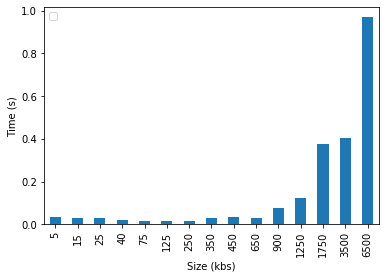

In [60]:
df = pd.DataFrame(stats_time_size_analysis)
df = df.set_index(df.columns[0])

df.plot(kind='bar')
plt.xlabel("Size (kbs)")
plt.ylabel("Time (s)")
plt.legend('')
plt.show()